### Forecasting Models 10.3
#### The ARMA framework
The last videos of the module took you through an approach to building ARMA models.

First, you learned about the importance of transforming your data into a stationary series. You tested for stationarity using the adfuller function and interpreted the value of the hypothesis test. If the data was not stationary, you learned how to apply strategies, such as differencing and logarithmic transformations, to achieve stationarity.

Once the series was stationary, building an ARMA model involved using autocorrelation and partial autocorrelation plots to determine the appropriate p and q parameters of the model.

This activity asks you to identify a time series of interest to you and build an ARMA model to construct a basic forecast for the series and analyze the error. You might also consider building models with different p and q parameters because, while ACF and PACF plots are helpful, they provide rough ideas of the appropriate parameters, and it is usually good practice to perform a simple grid search on these. 

Please find a time series dataset using any resource you would like, and present your model and findings to the class.


##### In this try-it activity I am using the Weekly Working Gas in Underground Storage dataset. 

##### Why Natural Gas Storage Data?
The weekly natural gas storage data is a principal federal economic indicator used by the public to determine natural gas inventory levels, indicators of the balance between supply and demand in the natural gas market. According to the U.S. Energy Information Administration, upon release of the report, the natural gas market reacts to the derived net change in inventory levels from the prior week that often influences natural gas prices.

#### Source of the dataset:
The dataset is from U.S. Energy Information Administration (EIA).
More info can be found here:
https://www.eia.gov/dnav/ng/ng_stor_wkly_s1_w.htm


##### Use of ARIMA and SARIMA (ARMA framework)
In addition, the use of ARMA framework is mandotory for the accurate forecasting of this seasonal dataset.

### Imports

In [1]:
# initial imports
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#####

import statsmodels.api as sm
#from statsmodels.tsa.filters.filtertools import convolution_filter
import statsmodels.graphics.tsaplots as tsplots
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.statespace.sarimax import SARIMAX



#####
from warnings import filterwarnings
filterwarnings('ignore')

### Helper functions

In [2]:
def plot_STL(seasonal_dec_object = None, plot_size = (10, 15), title = None ):
    """
    Plots the components of a Seasonal Decomposition object, including observed data, trend,
    seasonality, and residuals. The plot includes four subplots, each representing one of the
    components. Customizable plot size and title are available for better visualization.

    :param seasonal_dec_object: An object containing the results of a seasonal decomposition. The
        object should include the following attributes: `observed`, `trend`, `seasonal`, and `resid`.
    :param plot_size: Tuple specifying the size of the plot (width, height).
    :param title: Optional string to specify the title of the plot.
    :return: None, as the function directly displays the plot.
    """
    plt.figure(figsize=plot_size)

    plt.subplot(4, 1, 1)
    plt.title(title, fontsize = 15)
    sns.lineplot(data = seasonal_dec_object.observed, color = '#27374D')
    plt.ylabel('Observed')
    plt.xticks([])
    plt.xlabel('')

    plt.subplot(4, 1, 2)
    sns.lineplot(data = seasonal_dec_object.trend, color = '#176B87')
    plt.ylabel('Trend')
    plt.xticks([])
    plt.xlabel('')

    plt.subplot(4, 1, 3)
    sns.lineplot(data = seasonal_dec_object.seasonal, color = '#2E8A99')
    plt.ylabel('Seasonality')
    plt.xticks([])
    plt.xlabel('')

    plt.subplot(4, 1, 4)
    sns.lineplot(data = seasonal_dec_object.resid, color = '#C70039')
    plt.ylabel('Residuals')
    plt.xticks([])
    plt.xlabel('Time variable')
    plt.xticks(rotation=90)
    #
    ax = plt.gca()
    # change tick frequency, format
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    plt.gcf().autofmt_xdate()
    plt.show()

In [ ]:
# import Yahoo datasets or the dataset of Natural Gas
def import_data(data_from_Yahoo = True):
    """
    Imports and processes financial or natural gas storage data from specified sources.

    This function is used to import and prepare data for further analysis. It can
    either fetch crude oil or financial stock data using the Yahoo Finance API, or
    import natural gas storage data from a local Excel file. The imported data is
    formatted for consistency, and specific attributes such as date ranges and
    dataset length are printed.

    :param data_from_Yahoo: A flag indicating the data source. If True, data is
                            fetched from Yahoo Finance. If False, local Excel data
                            is used.
                            Default value is True.
    :type data_from_Yahoo: bool

    :return: A DataFrame containing the processed data. Includes specific columns
             like 'Close' if Yahoo Finance data is used or 'NG Storage' for natural
             gas storage data.
    :rtype: pandas.DataFrame
    """
    if data_from_Yahoo == True:
        import yfinance as yf
        #### download and format data
        #tick = yf.Ticker("CL=F") #crude oil price in USD
        #data = tick.history(period='5y', interval='1wk')
        
        tick = yf.Ticker("COLM")
        data = tick.history(period='1y', interval='1d')
        data.index = data.index.strftime('%d-%m-%Y')
        ####
        print('The starting date is: ' + str(min(data.index)))
        print('The ending date is: ' + str(max(data.index)))
        print('The length of the time-series is: ' + str(len(data)) +' obesrvations')
        data['Close'].tail()
        #saving data to df - use only df from now on:
        df = data[['Close']]
    else:
        data = pd.read_excel('NG_STOR_WKLY_S1_W.xlsx', sheet_name='to_use')
        data = data.set_index('Date')
        data.index = data.index.strftime('%d-%m-%Y')
        data = data.rename(columns={'Weekly Lower 48 States Natural Gas Working Underground Storage (Billion Cubic Feet)':'NG Storage'})
        df = data
        
    return df

### Import of the dataset (Natural Gas Storage)

            NG Storage
Date                  
13-10-2023        3626
20-10-2023        3700
27-10-2023        3779
03-11-2023        3773
10-11-2023        3833


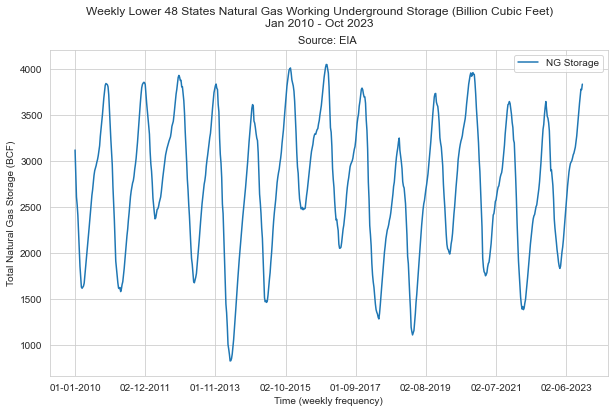

In [52]:
df = import_data(data_from_Yahoo = False)
df.plot(figsize = (10,6))
plt.title('Source: EIA ', fontsize = 11)
plt.suptitle('Weekly Lower 48 States Natural Gas Working Underground Storage (Billion Cubic Feet)\nJan 2010 - Oct 2023')
plt.ylabel('Total Natural Gas Storage (BCF)')
plt.xlabel('Time (weekly frequency)');
print(df.tail())

### Splitting the data into training and testing sets

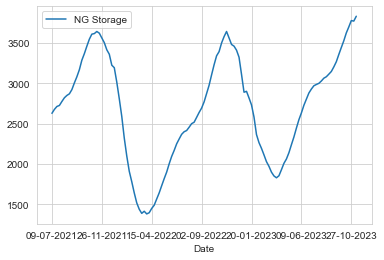

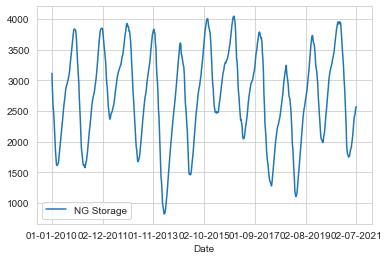

In [4]:
# split the data to X_train, X_test - weekly frequency
X_train = df.loc[:'02-07-2021']
X_test =  df.loc['09-07-2021':] # forecasting horizon:  09-Jul-2021 TO 10-Nov-2023

X_test.plot();
X_train.plot();

### ARIMA functions

In [44]:
# evaluate an ARIMA model for a given order (p,d,q) ###########################################################################
def evaluate_arima_model(value_name = 'NG Storage', X_train=X_train, X_test=X_test, arima_order = (1,0,1), seasonality = False, sarima_order = (1,0,1,12)):
    """
    Evaluates the ARIMA model using given training and test datasets. It allows for seasonal ARIMA
    (SARIMA) evaluation as well. This function computes predictions for both the training dataset
    and the test dataset, followed by the calculation of residuals and evaluation metrics such as
    MAE (Mean Absolute Error) and RMSE (Root Mean Square Error). The function returns the RMSE value
    as a measure of the predictive accuracy of the model.

    :param value_name: Name of the dependent variable for which the ARIMA model is being evaluated.
                       Required for calculating residuals.
    :type value_name: str
    :param X_train: Training dataset used to fit the ARIMA or SARIMA model.
    :type X_train: pandas.DataFrame or pandas.Series
    :param X_test: Test dataset used for making predictions and evaluating the model's performance.
    :type X_test: pandas.DataFrame or pandas.Series
    :param arima_order: A tuple of integers specifying the non-seasonal ARIMA order (p, d, q).
                        Default is (1, 0, 1).
    :type arima_order: tuple
    :param seasonality: A boolean flag indicating whether to apply seasonal ARIMA (SARIMA).
                        If True, SARIMA will be used. Default is False.
    :type seasonality: bool
    :param sarima_order: A tuple of integers specifying the seasonal ARIMA order (P, D, Q, s) if
                         seasonality is enabled. Default is (1, 0, 1, 12).
    :type sarima_order: tuple

    :return: The Root Mean Square Error (RMSE) of the model predictions on the test dataset.
    :rtype: float
    """
    #initialise ARMA
    if seasonality==False: arma = ARIMA(X_train, order = arima_order).fit()
    else: arma = ARIMA(X_train, seasonal_order = sarima_order).fit()
    X_train_preds = arma.predict()
    # make predictions
    future_preds_Xtest = arma.forecast(steps = len(X_test))
    forecast = pd.DataFrame({'Forecast': future_preds_Xtest,
                             'Date': X_test.index}).set_index('Date')
    # calculate out of sample error
    resids = X_test[value_name] - forecast['Forecast']
    mae = np.abs(resids).mean()
    rmse = np.sqrt((resids**2).mean())
    return rmse

################################################################

# evaluate combinations of p, d and q values for an ARIMA model:
def evaluate_models_ARIMA(p_values, d_values, q_values, X_train = X_train, X_test = X_test):
    """
    Evaluates combinations of ARIMA model parameters and selects the optimal configuration
    based on the root mean square error (RMSE). The function iterates through all possible
    combinations of specified p, d, and q values to identify the ARIMA configuration that
    produces the best predictive performance when applied to the test dataset.

    :param p_values: List of integers representing the p-parameters (autoregressive terms)
        for ARIMA configuration.
    :param d_values: List of integers representing the d-parameters (differencing order)
        for ARIMA configuration.
    :param q_values: List of integers representing the q-parameters (moving average terms)
        for ARIMA configuration.
    :param X_train: Training dataset used for fitting the ARIMA models.
    :param X_test: Test dataset used to evaluate the predictive performance (RMSE) of ARIMA
        models.
    :return: The configuration of ARIMA parameters (p, d, q) that results in the lowest RMSE
        when tested on the given dataset.
    """
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                arima_order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(X_train = X_train, X_test = X_test, arima_order= arima_order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, arima_order
                        print('ARIMA%s RMSE=%.3f' % (arima_order,rmse))
                except: continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    return best_cfg

############################


# evaluate combinations of p, d, q and S values for an SARIMA model:
def evaluate_models_SARIMA(p_values, d_values, q_values,S_values, X_train = X_train, X_test = X_test):
    """
    Evaluates SARIMA models for provided ranges of parameters to determine the best configuration
    based on Root Mean Square Error (RMSE). The function iterates through all combinations
    of `(p, d, q, s)` parameters and computes the RMSE for each configuration using the training
    and test datasets. The SARIMA configuration that produces the lowest RMSE score is returned.

    :param p_values: A range or list of non-negative integers specifying the values for
        the autoregressive (AR) order (p) in the model.
    :param d_values: A range or list of integers specifying the values for the differencing
        (d) order parameter in the model.
    :param q_values: A range or list of non-negative integers specifying the values for
        the moving average (MA) order (q) in the model.
    :param S_values: A range or list of integers specifying the seasonal period length
        (S) used in the SARIMA model.
    :param X_train: The training dataset used to fit the SARIMA model.
    :param X_test: The testing dataset used to evaluate the SARIMA model's performance.
    :return: A tuple specifying the best SARIMA configuration `(p, d, q, s)` that produces
        the lowest RMSE value.
    """
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for s in S_values:
                    sarima_order = (p,d,q,s)
                    try:
                        rmse = evaluate_arima_model(X_train = X_train, X_test = X_test, sarima_order = sarima_order, seasonality = True)
                        if rmse < best_score:
                            best_score, best_cfg = rmse, sarima_order
                            print('SARIMA%s RMSE=%.3f' % (sarima_order,rmse))
                    except: continue
    print('Best SARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    return best_cfg

###########################

### Apply the function to evaluate the ARIMA model

In [45]:
# initialise parameters -- AR-MA (p,d,q)
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 2)
q_values = range(0, 5)
best_cfg_arima = evaluate_models_ARIMA(p_values = p_values, d_values = d_values, q_values = q_values )

ARIMA(0, 0, 0) RMSE=664.678
ARIMA(0, 0, 1) RMSE=664.619
ARIMA(2, 0, 0) RMSE=658.730
ARIMA(2, 0, 1) RMSE=593.372
ARIMA(2, 0, 2) RMSE=585.482
ARIMA(4, 1, 4) RMSE=571.613
Best ARIMA(4, 1, 4) RMSE=571.613


In [46]:
#initialise parameters --  S-AR-MA (p,d,q, S) 
p_values = range(1, 8)
d_values = [1]
q_values = range(1, 8)
S_values = [12] 
evaluate_models_SARIMA(p_values = p_values, d_values = d_values, q_values = q_values, S_values = S_values )

SARIMA(1, 1, 1, 12) RMSE=670.427
SARIMA(1, 1, 2, 12) RMSE=663.047
SARIMA(1, 1, 3, 12) RMSE=639.078
SARIMA(1, 1, 4, 12) RMSE=630.223
SARIMA(1, 1, 5, 12) RMSE=623.668
SARIMA(1, 1, 6, 12) RMSE=494.009
SARIMA(2, 1, 2, 12) RMSE=383.900
SARIMA(2, 1, 3, 12) RMSE=373.286
SARIMA(2, 1, 4, 12) RMSE=334.222
SARIMA(2, 1, 5, 12) RMSE=319.893
SARIMA(2, 1, 6, 12) RMSE=280.917
SARIMA(3, 1, 7, 12) RMSE=276.476
SARIMA(4, 1, 4, 12) RMSE=255.891
SARIMA(5, 1, 1, 12) RMSE=235.432
SARIMA(5, 1, 4, 12) RMSE=225.373
SARIMA(6, 1, 2, 12) RMSE=158.000
Best SARIMA(6, 1, 2, 12) RMSE=158.000


(6, 1, 2, 12)

#### Residuals plotting and checking stationarity

Are the residuals stationary? -- yes


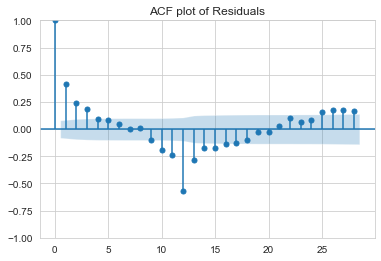

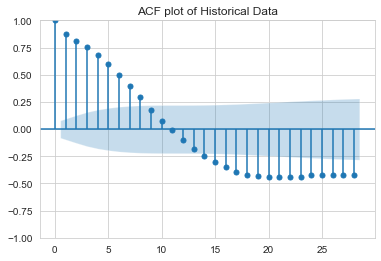

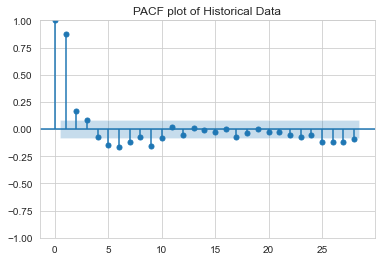

In [9]:
### choose diff for data !!!!!!
difference = 1
STLperiod_ = 12
###############################
results = None
if difference == 0:
    stl = STL(X_train, period = STLperiod_)
    results = stl.fit()
    ans = 'yes' if adfuller(results.resid)[1] < 0.05 else 'no'
    print("Are the residuals stationary? -- "+ ans )

    plot_acf(results.resid)
    plt.title('ACF plot of Residuals');
    
    plot_acf(X_train)
    plt.title('ACF plot of Historical Data');

    plot_pacf(X_train, method='ywm')
    plt.title('PACF plot of Historical Data');
    
else:
    stl = STL(X_train.diff(difference).dropna(), period = STLperiod_)
    results = stl.fit()
    ans = 'yes' if adfuller(results.resid)[1] < 0.05 else 'no'
    print("Are the residuals stationary? -- "+ ans )

    plot_acf(results.resid)
    plt.title('ACF plot of Residuals');
    
    plot_acf(X_train.diff(difference).dropna())
    plt.title('ACF plot of Historical Data');

    plot_pacf(X_train.diff(difference).dropna(), method='ywm')
    plt.title('PACF plot of Historical Data');

#plot_STL(seasonal_dec_object = results, plot_size = (15, 12), title = 'STL - T.S. Decomposition - Weekly Lower 48 States Natural Gas Working Underground Storage (Billion Cubic Feet)');   


#### Initialising the ARMA model

In [47]:
#initialise ARMA

#arma = ARIMA(X_train, order = best_cfg_arima).fit()  
#arma = ARIMA(X_train, seasonal_order = best_cfg_sarima).fit()

arma = ARIMA(X_train, seasonal_order = (6,1,2,12)).fit()  #

X_train_preds = arma.predict()

prediction = pd.DataFrame({'Prediction': X_train_preds,
                         'Date': X_train.index}).set_index('Date')

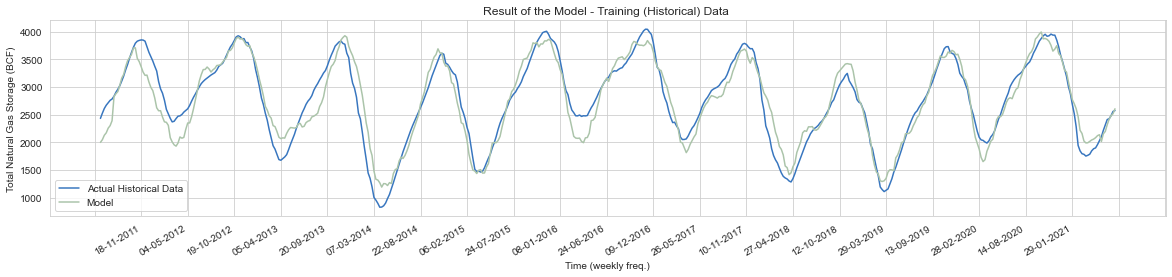

Train MAE: 306.39
Train RMSE: 513.89


In [59]:
#################
#plotting:
plt.figure(figsize = (20, 4))
plt.plot(X_train.loc['24-06-2011':], label = 'Actual Historical Data', color = '#3876BF')
plt.plot(X_train_preds.loc['24-06-2011':], label = 'Model', color = '#ABC4AA')
plt.legend()
#plt.grid()
plt.title('Result of the Model - Training (Historical) Data ')
plt.ylabel('Total Natural Gas Storage (BCF)', fontsize = 10)
plt.xlabel('Time (weekly freq.)', fontsize = 10)
plt.xticks(rotation=45)
#
ax = plt.gca()
# change tick frequency, format
ax.xaxis.set_major_locator(mdates.DayLocator(interval=24))
plt.gcf().autofmt_xdate()
plt.show()
#################

#################
#### MAE --- RMSE
resids_train = X_train['NG Storage'] - prediction['Prediction']
mae_train = np.abs(resids_train).mean()
rmse_train = np.sqrt((resids_train**2).mean())

print(f'Train MAE: {np.round(mae_train,2)}')
print(f'Train RMSE: {np.round(rmse_train, 2)}')

#### Forecasting with ARMA MODEL

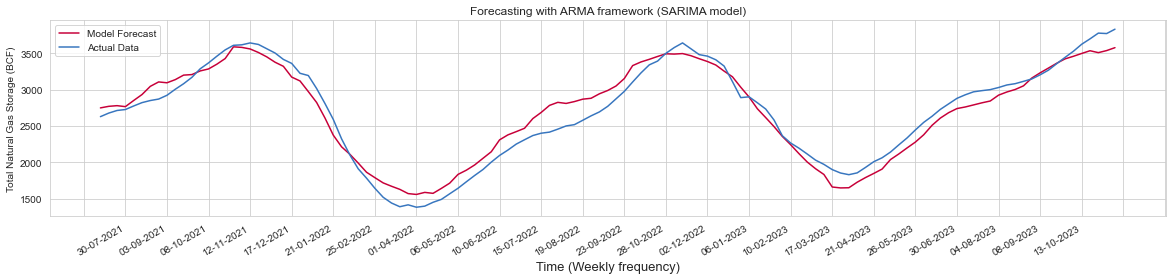

In [55]:
future_preds_Xtest = None
forecast = None
#X_test.index = pd.to_datetime(X_test.index)
future_preds_Xtest = arma.forecast(steps = len(X_test))
forecast = pd.DataFrame({'Forecast': future_preds_Xtest,
                         'Date': X_test.index}).set_index('Date')

#forecast.index = forecast.index.strftime('%d-%m-%Y')
#X_test.index = X_test.index.strftime('%d-%m-%Y')

#plotting:
plt.figure(figsize = (20, 4))
plt.plot(forecast, label = 'Model Forecast', color = '#C70039')
plt.plot(X_test, label = 'Actual Data', color = '#3876BF')
plt.legend()
#plt.grid()
plt.title('Forecasting with ARMA framework (SARIMA model)')
plt.xlabel('Time (Weekly frequency)',fontsize = 13)
plt.ylabel('Total Natural Gas Storage (BCF)', fontsize = 10)
plt.xticks(rotation=45)

ax = plt.gca()
# change tick frequency, format
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.gcf().autofmt_xdate()
plt.show()


Determination of the stationarity of the results by examining the autocorrelation plot of the residuals.  Is there structure remaining in the series based on this?

Forecast MAE: 138.38
Forecast RMSE: 158.0


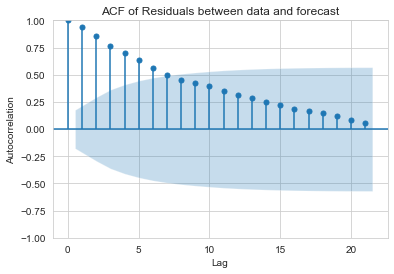

In [58]:
resids = X_test['NG Storage'] - forecast['Forecast']
mae = np.abs(resids).mean()
rmse = np.sqrt((resids**2).mean())

print(f'Forecast MAE: {np.round(mae,2)}')
print(f'Forecast RMSE: {np.round(rmse, 2)}')

plot_acf(resids) #lags=20)
plt.title('ACF of Residuals between data and forecast')
plt.ylabel('Autocorrelation')
plt.xlabel('Lag');

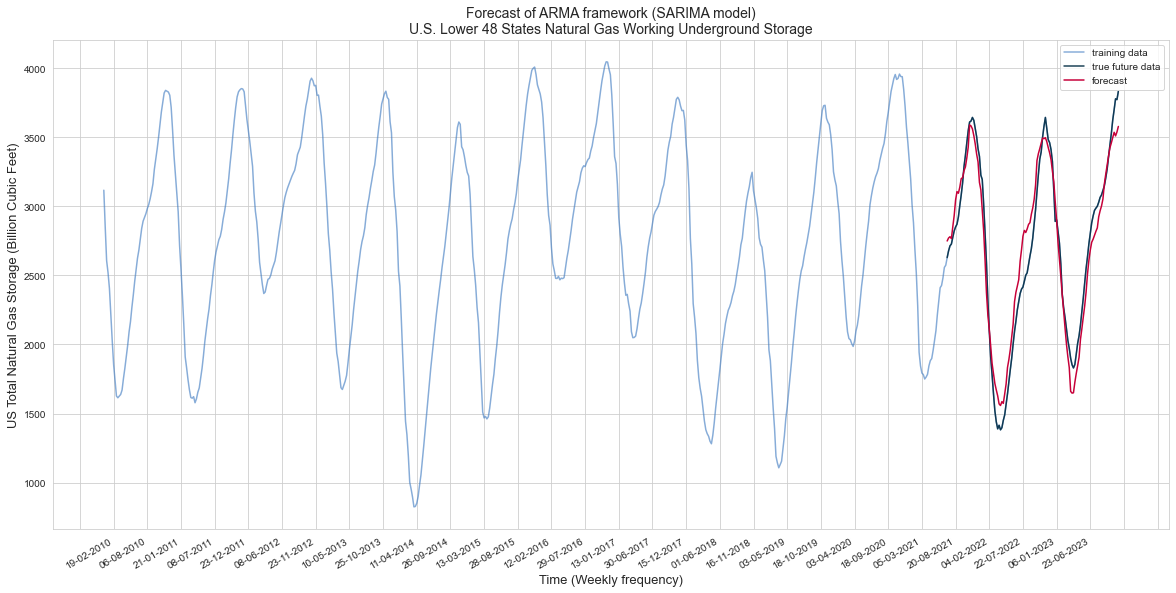

In [51]:
plt.figure(figsize=(20,10))
plt.plot(df, label = 'training data', color = '#3876BF', alpha = 0.6)
plt.plot(X_test, label = 'true future data', color = '#022C43', alpha = 0.9)
plt.plot(forecast['Forecast'], label = 'forecast', color = '#C70039')
#plt.plot(X_train, label = 'training data', color = '#3876BF', alpha = 0.6)
#plt.plot(results.trend, label = 'trend', color = '#192655' )
plt.legend()
plt.title('Forecast of ARMA framework (SARIMA model)\nU.S. Lower 48 States Natural Gas Working Underground Storage', fontsize = 14)
plt.xlabel('Time (Weekly frequency)',fontsize = 13)
plt.ylabel('US Total Natural Gas Storage (Billion Cubic Feet)', fontsize = 13)
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45)
#######################
ax = plt.gca()
# change tick frequency, format
ax.xaxis.set_major_locator(mdates.DayLocator(interval=24))
plt.gcf().autofmt_xdate();

#### Summary of the model

In [61]:
arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                  
===================================================================================
Dep. Variable:                  NG Storage   No. Observations:                  601
Model:             ARIMA(6, 1, [1, 2], 12)   Log Likelihood               -4198.241
Date:                     Fri, 17 Nov 2023   AIC                           8414.482
Time:                             21:54:15   BIC                           8453.888
Sample:                                  0   HQIC                          8429.835
                                     - 601                                         
Covariance Type:                       opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.0073      0.044      0.165      0.869      -0.080       0.094
ar.S.L24       0.4951      0.042     11.729      0.000       0.412       0.578
ar.S.L36      -0.4974      0.037    -13.297      0.000      -0.571      -0.424
ar.S.L48       0.5739      0.039     14.662      0.000       0.497       0.651
ar.S.L60       0.2791      0.037      7.499      0.000       0.206       0.352
ar.S.L72      -0.7663      0.040    -19.168      0.000      -0.845      -0.688
ma.S.L12      -0.1095      0.149     -0.735      0.463      -0.402       0.183
ma.S.L24      -0.8324      0.122     -6.809      0.000      -1.072      -0.593
sigma2       8.88e+04    1.2e+04      7.378      0.000    6.52e+04    1.12e+05
===================================================================================
Ljung-Box (L1) (Q):                 538.30   Jarque-Bera (JB):                 0.51
Prob(Q):                              0.00   Prob(JB):                         0.77
Heteroskedasticity (H):               0.34   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""